# Reproduction rate

Here, the reproducation rate is computed using the [logistic map](https://en.wikipedia.org/wiki/Logistic_map):



Solving for r, I [got](https://www.wolframalpha.com/input/?i=Solve+n%28t%2B1%29+%3D+r*n%28t%29*%281-n%28t%29%29+for+r) `r = n(t+1) / (n(t)-n²(t))`.

*Data*: [@entorb](https://github.com/entorb/COVID-19-Coronavirus-German-Regions)'s dataset.

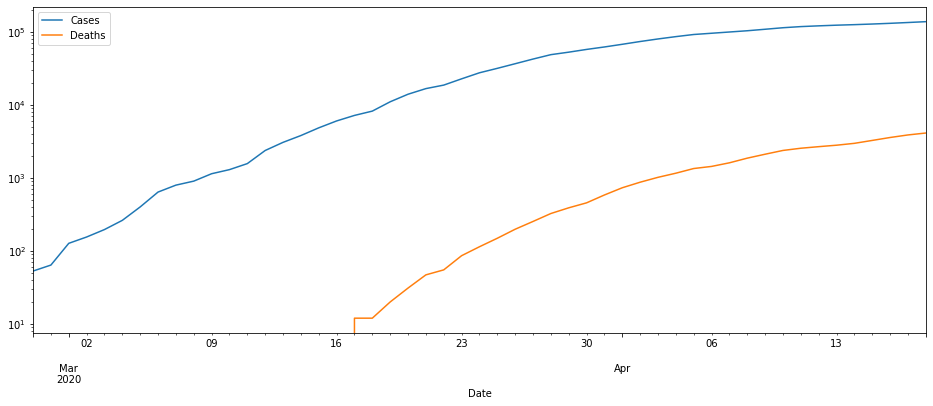

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from scrape import entorb

de = entorb.to_dataframe('DE-total')
de.plot(y=['Cases', 'Deaths'], logy=True, figsize=(16,6))

In [2]:
def compute_r(df, n_max = 81e6):
    rs = pd.DataFrame()
    for col in ['Deaths', 'Cases']:
        for rolling in ['1D', '7D', '30D']:
            normalized = df[col].rolling(rolling).mean() / n_max
            earlier = normalized.shift(1)
            rs[col+' (last '+rolling.replace('D', ' days')+')'] = normalized / earlier / ([1]*len(earlier) - earlier)
    return rs

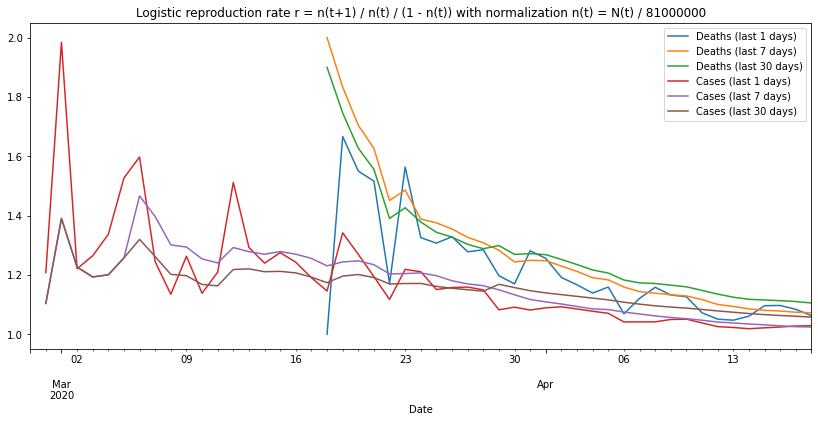

In [3]:
N_MAX = 81e6
rs = compute_r(de, N_MAX)
ax = rs.plot(figsize=(14,6),
        title="Logistic reproduction rate r = n(t+1) / n(t) / (1 - n(t)) with normalization n(t) = N(t) / %d" % N_MAX)

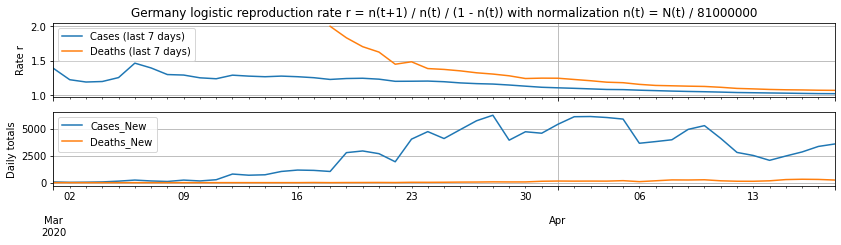

In [4]:
since = '2020-03-01'
fig, axes = plt.subplots(nrows=2, sharex=True)
rs[['Cases (last 7 days)', 'Deaths (last 7 days)']][rs.index >= since].plot(figsize=(14,3), ax=axes[0], kind='line', stacked=False,
        title="Germany logistic reproduction rate r = n(t+1) / n(t) / (1 - n(t)) with normalization n(t) = N(t) / %d" % N_MAX)
axes[0].set_ylabel('Rate r')
#axes[0].set_ylim(0.5, 1.5)
axes[0].grid(True)
axes[0].legend(loc='upper left')

de[de.index >= since].plot(y=['Cases_New', 'Deaths_New'], ax=axes[1], kind='line', figsize=(14,3), stacked=False)
axes[1].set_ylabel('Daily totals')
axes[1].set_xlabel('')
axes[1].grid(True)
axes[1].legend(loc='upper left')

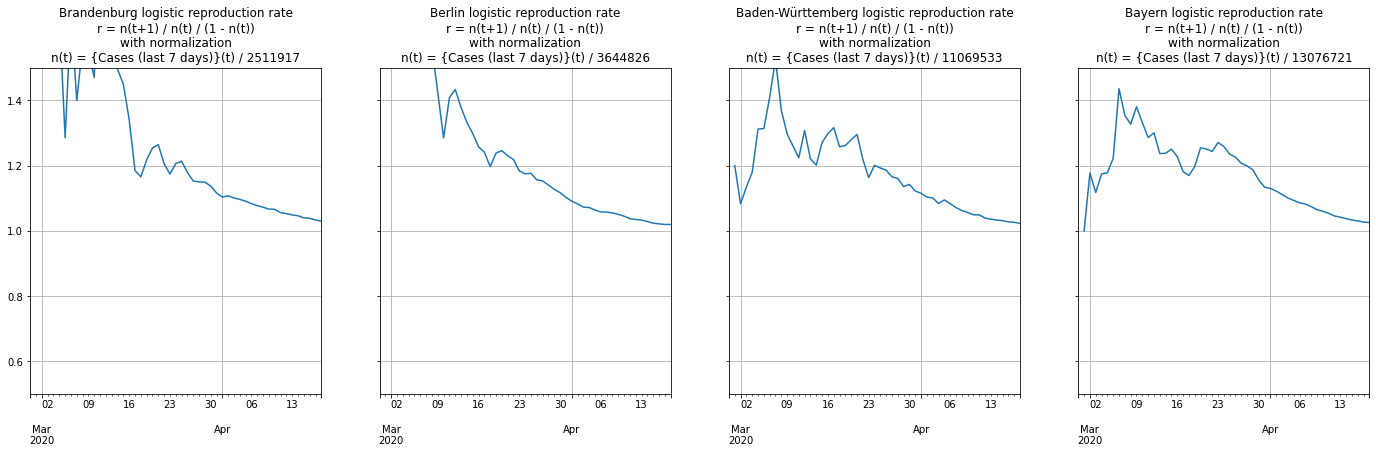

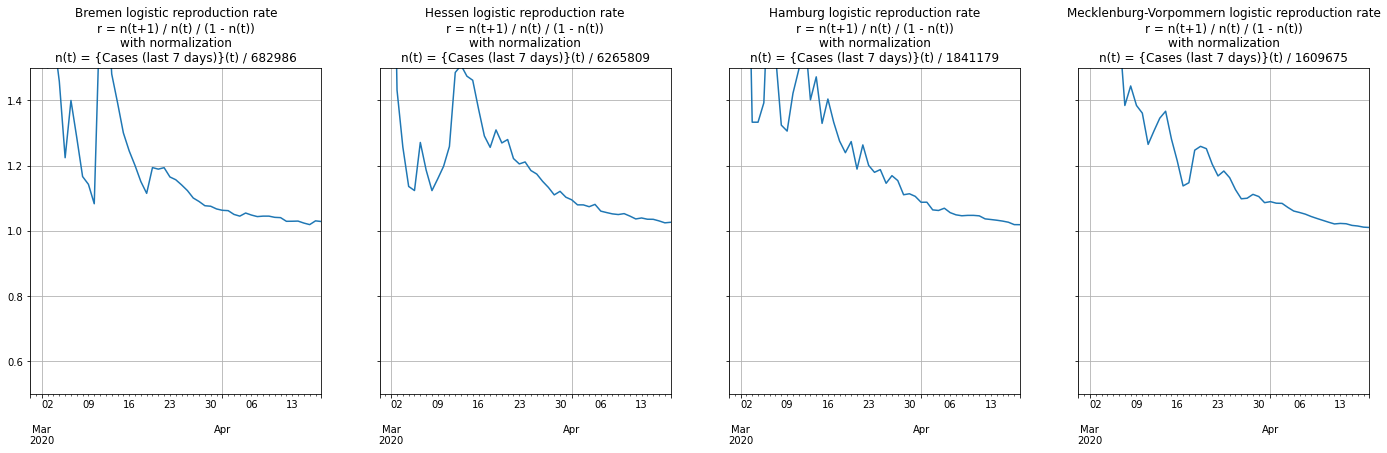

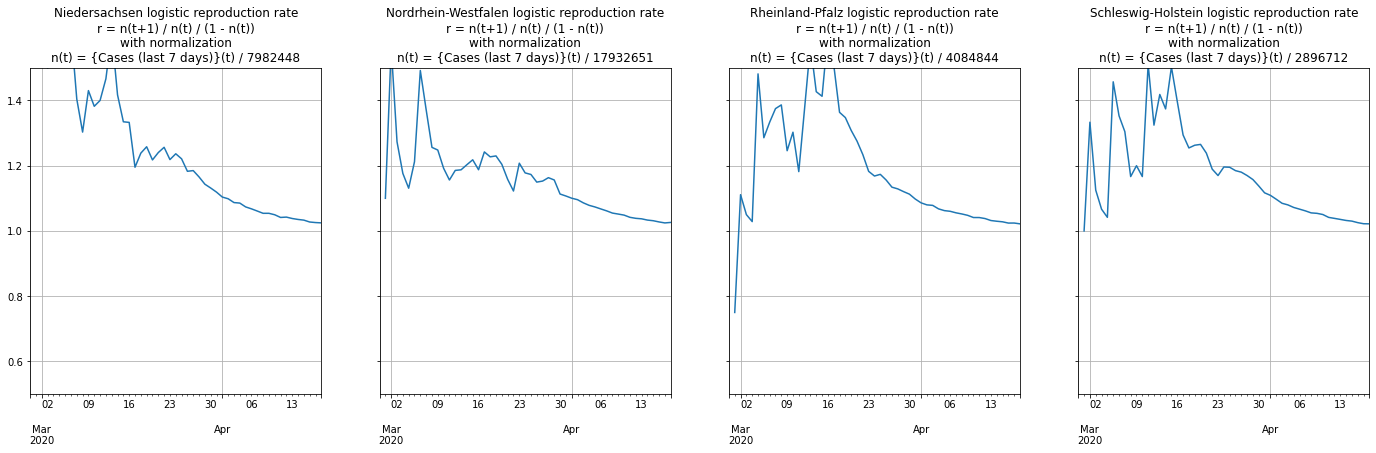

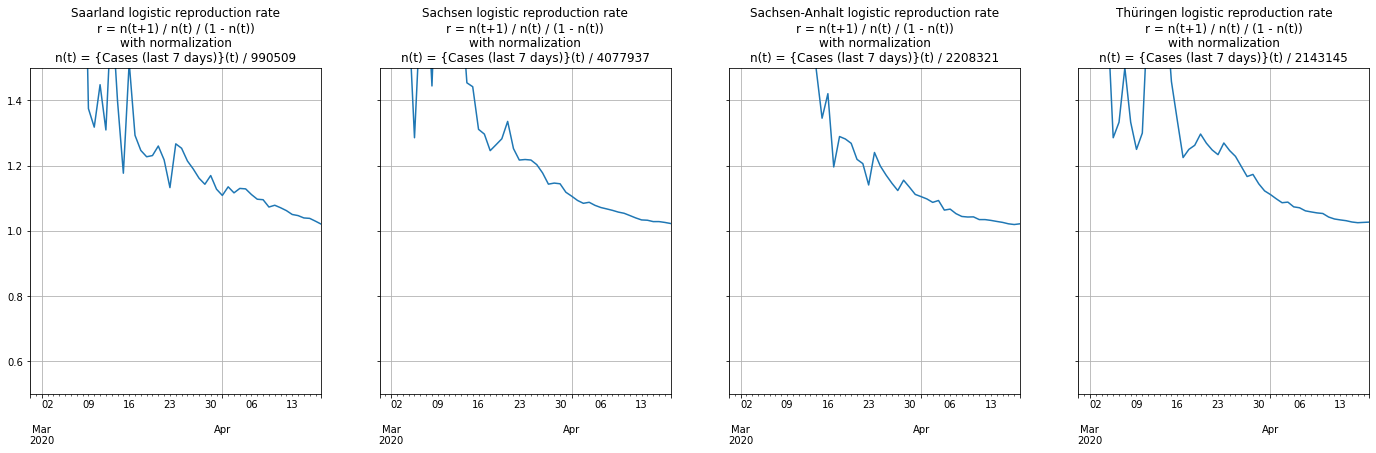

In [5]:
from scrape.scrape import federal_state_translation as fst

population = {
    'Baden-Württemberg': 11069533,
    'Bayern': 13076721,
    'Berlin': 3644826,
    'Brandenburg': 2511917,
    'Bremen': 682986,
    'Hamburg': 1841179,
    'Hessen': 6265809,
    'Mecklenburg-Vorpommern': 1609675,
    'Niedersachsen': 7982448,
    'Nordrhein-Westfalen': 17932651,
    'Rheinland-Pfalz': 4084844,
    'Saarland': 990509,
    'Sachsen': 4077937,
    'Sachsen-Anhalt': 2208321,
    'Schleswig-Holstein': 2896712,
    'Thüringen': 2143145,
}

def plot_r(col='Cases (last 7 days)', ncols=4):
    lasts = []
    for offset in range(0,len(fst), ncols):
        areas = sorted([x for x in fst])[offset:offset+ncols]
        fig, axes = plt.subplots(ncols=ncols, sharey=True)
        for i, area in enumerate(areas):
            de = entorb.to_dataframe(area)
            n_max = population[fst[area]]
            rs = compute_r(de, n_max)
            lasts.append(rs.last('1D').mean()[col])
            axes[i%ncols] = rs.plot(y=col,
                                    figsize=(ncols*6,6),
                                    ax=axes[i%ncols],
                                    legend=False,
                                    title="%s logistic reproduction rate\nr = n(t+1) / n(t) / (1 - n(t))\nwith normalization\nn(t) = {%s}(t) / %d" % (fst[area], col, n_max))
            axes[i%ncols].set_ylim(0.5,1.5)
            axes[i%ncols].set_xlabel('')
            axes[i%ncols].grid()
    return lasts

lasts = plot_r()

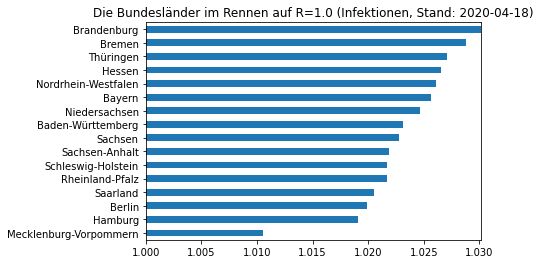

In [6]:
from datetime import datetime

current_r = pd.DataFrame({'R': lasts}, index=[fst[x] for x in sorted([y for y in fst])])
current_r.sort_values('R').plot(kind='barh',
               xlim=(min(1.0, min(lasts)), max(lasts)),
               legend=False, grid=False,
               title="Die Bundesländer im Rennen auf R=1.0 (Infektionen, Stand: %s)" % (datetime.now().strftime('%Y-%m-%d')))

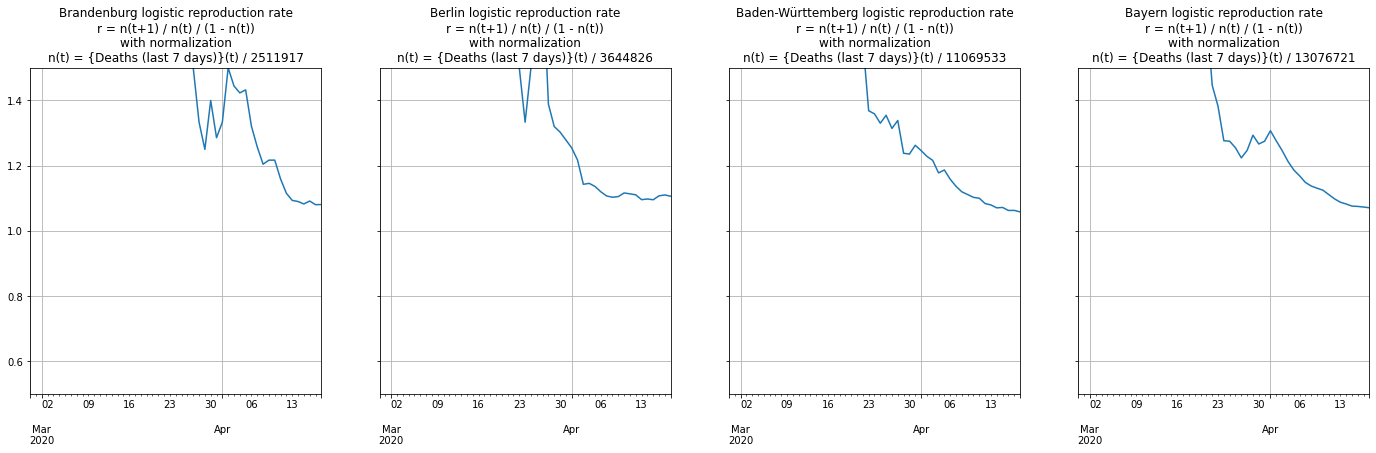

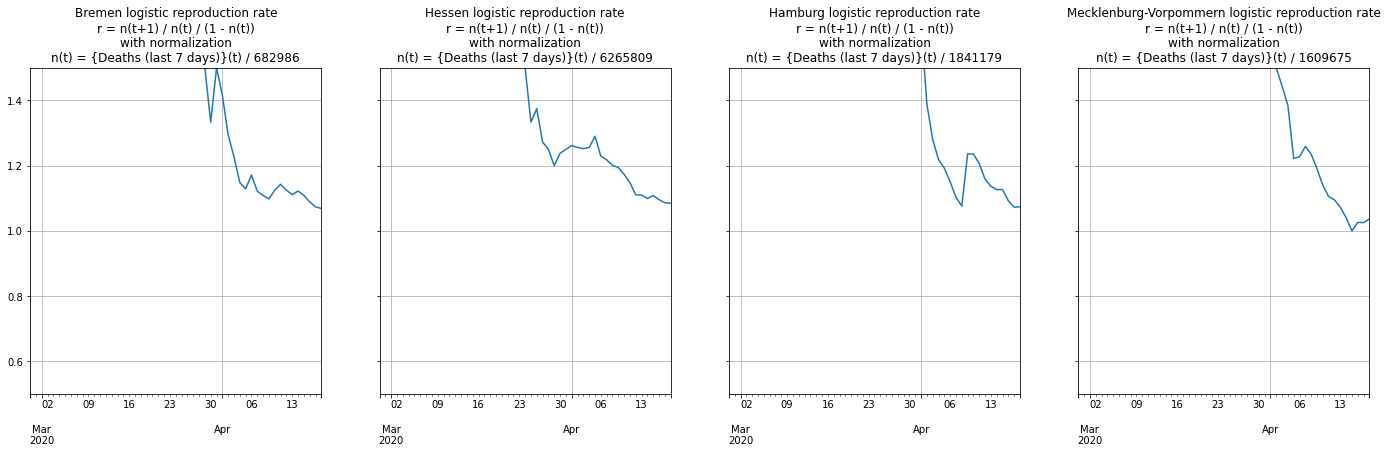

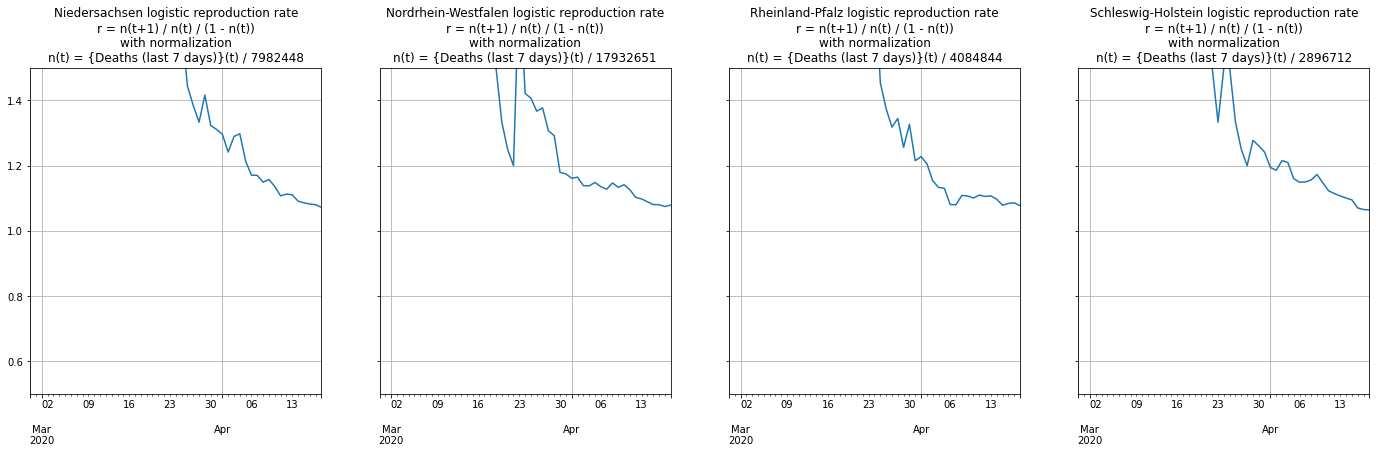

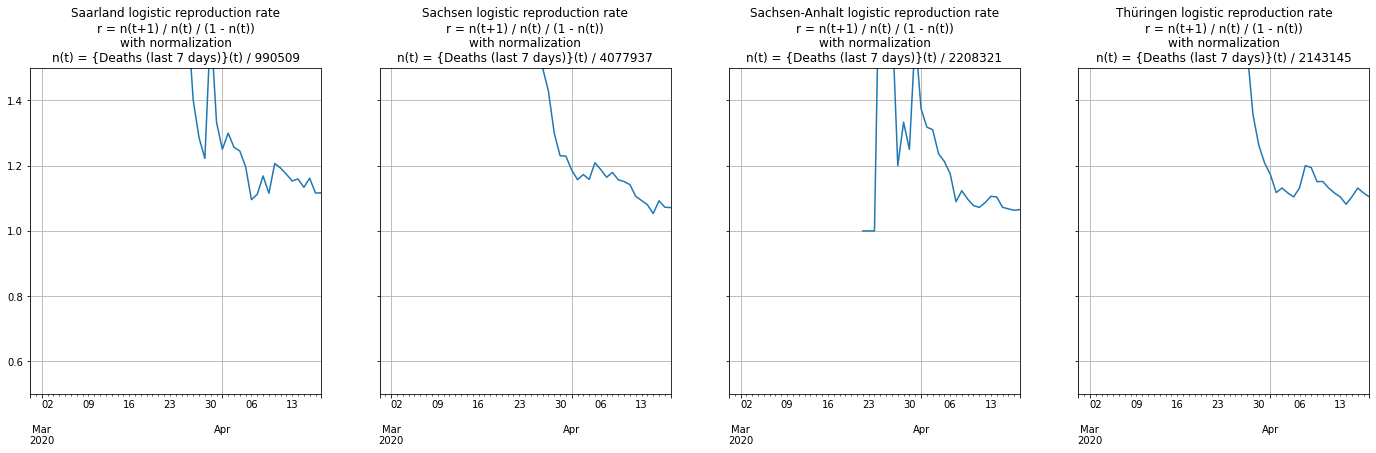

In [7]:
lasts = plot_r(col='Deaths (last 7 days)')

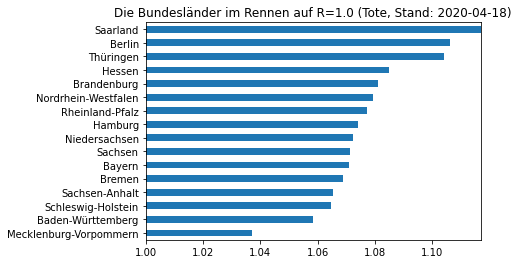

In [8]:
from datetime import datetime

current_r = pd.DataFrame({'R': lasts}, index=[fst[x] for x in sorted([y for y in fst])])
current_r.sort_values('R').plot(kind='barh',
               xlim=(min(1.0, min(lasts)), max(lasts)),
               legend=False, grid=False,
               title="Die Bundesländer im Rennen auf R=1.0 (Tote, Stand: %s)" % (datetime.now().strftime('%Y-%m-%d')))